# Assignment 4
### Do three of six.

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
  - See plots below.
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("./data/mn_police_use_of_force.csv")

df['injury_na'] = df['subject_injury'].isna() # Create a missing value dummy
df['injury_na'].value_counts() # How many missings?

df.head()

,response_datetime,problem,is_911_call,primary_offense,subject_injury,force_type,force_type_action,race,sex,age,type_resistance,precinct,neighborhood,injury_na
0,2016/01/01 00:47:36,Assault in Progress,Yes,DASLT1,NaN,Bodily Force,Body Weight to Pin,Black,Male,20.0,Tensed,1,Downtown East,True
1,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,Black,Female,27.0,Verbal Non-Compliance,1,Downtown West,True
2,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,White,Female,23.0,Verbal Non-Compliance,1,Downtown West,True
3,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West,True
4,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West,True


In [6]:
## Our statistic to bootstrap:
def stat(x):
    stat = x.isna().mean()
    return stat

/var/folders/dg/qy7075ls2lv5xq69xksqp9180000gn/T/ipykernel_93454/2745266760.py:47: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=boot_df, x="estimate", hue="race", ax=axes[0])


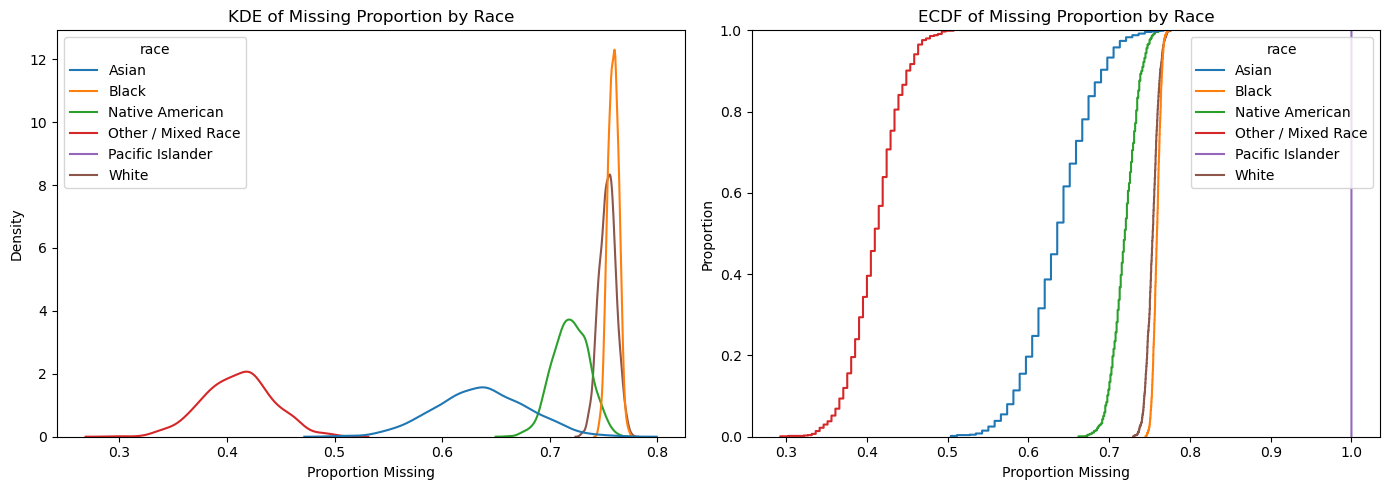

,race,estimate
0,Asian,0.682171
1,Asian,0.658915
2,Asian,0.573643
3,Asian,0.620155
4,Asian,0.596899
...,...,...
5995,White,0.748162
5996,White,0.751997
5997,White,0.752637
5998,White,0.741131


In [8]:
def simulate(var, df, fcn, S=1000, plot=True):
    ''' Bootstrap simulation code. '''    
    x = df[var]

    estimates = []
    for s in range(S):
        # Draw a new sample, with replacement:
        x_s = x.sample(frac=1.0,replace=True)
        # Compute statistic:
        stat_s = fcn(x_s)
        # Append estimate:
        estimates.append(stat_s)
    estimates = np.array(estimates) # Convert estimates list to numpy array

    ## or in one line, 
    #estimates = [fcn(x.sample(frac=1.0,replace=True)) for s in range(S)]

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax = axes[1]).set(title='KDE of Computed Statistics')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax = axes[2]).set(title='ECDF of Computed Statistics')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
        
    return estimates

#save results by race and estimates
bootstrap_results = {}
for race, group in df.groupby("race"):
    estimates = simulate("subject_injury", group, stat, plot=False)
    bootstrap_results[race] = estimates

# Combine into DataFrame of race and 1000 bootstrapped estimates for plotting
boot_df = (
    pd.DataFrame({
        "race": np.repeat(list(bootstrap_results.keys()), [len(v) for v in bootstrap_results.values()]),
        "estimate": np.concatenate(list(bootstrap_results.values()))
    })
)

# Now do grouped plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(data=boot_df, x="estimate", hue="race", ax=axes[0])
axes[0].set(title="KDE of Missing Proportion by Race", xlabel="Proportion Missing")

sns.ecdfplot(data=boot_df, x="estimate", hue="race", ax=axes[1])
axes[1].set(title="ECDF of Missing Proportion by Race", xlabel="Proportion Missing")

plt.tight_layout()
plt.show()
boot_df

Based on the above KDE/ECDF plots, the sampling distributions of the proportions by race are different, with Other/Mixed Race and Asian having a lower proportion of missing values, but also a larger spread/range of values when bootstrapping. For White and Black, the proportion of missing values is quite high around 0.75 and is also much more dense/concentrated around these high values without much variation. For Pacific Isalnder, all values of `subject injury` are missing as seen on the ECDF, so its KDE plot is not shown.

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

In [5]:
# Import Libraries: 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [12]:
ames = pd.read_csv(r"data\ames_prices.csv")
ames.head()

,Order,PID,area,price,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,...,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition
0,1,526301100,1656,215000,20,RL,141.0,31770,Pave,NaN,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
1,2,526350040,896,105000,20,RH,80.0,11622,Pave,NaN,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
2,3,526351010,1329,172000,20,RL,81.0,14267,Pave,NaN,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
3,4,526353030,2110,244000,20,RL,93.0,11160,Pave,NaN,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
4,5,527105010,1629,189900,60,RL,74.0,13830,Pave,NaN,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [14]:
# Simulate Function
## Our statistic to bootstrap:
def stat(x):
    stat = np.mean(x)
    return stat

def simulate(var, df, fcn, S=1000, plot=True):
    ''' Bootstrap simulation code. '''    
    x = df[var]

    estimates = []
    for s in range(S):
        # Draw a new sample, with replacement:
        x_s = x.sample(frac=1.0,replace=True)
        # Compute statistic:
        stat_s = fcn(x_s)
        # Append estimate:
        estimates.append(stat_s)
    estimates = np.array(estimates) # Convert estimates list to numpy array

    ## or in one line, 
    #estimates = [fcn(x.sample(frac=1.0,replace=True)) for s in range(S)]

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns
        sns.kdeplot(x, ax = axes[0]).set(title='KDE of Underlying Data')
        sns.kdeplot(estimates, ax = axes[1]).set(title='KDE of Computed Statistics')
        axes[1].axvline(x=fcn(x), color='orange', linestyle='--')
        sns.ecdfplot(estimates, ax = axes[2]).set(title='ECDF of Computed Statistics')
        axes[2].axvline(x=fcn(x), color='orange', linestyle='--')
        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')
        
    return estimates

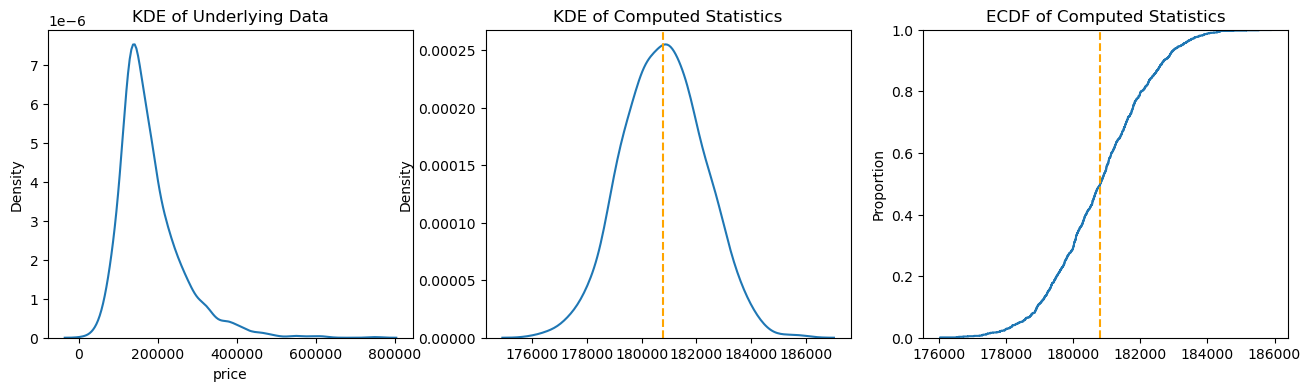

Variance of estimates is: 2181960.741379817


In [18]:
# Simulate Function Call
estimates = simulate('price', ames, stat)

In [28]:
# Interval Function
def interval(L, H, estimates):
    high = np.quantile(estimates, H)
    low = np.quantile(estimates, L)
    return high, low

H, L = interval(.05, .95, estimates)

print(f'The 90% confidence interval for the mean home price after bootstrapping is from {L:,.0f} to {H:,.0f} USD.')

The 90% confidence interval for the mean home price after bootstrapping is from 178,408 to 183,227 USD.


### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

#### The goal of the trial is to evalute whether the invasive treatment of ISCHEMIA-CKD through cardiac catheterization and revascularization, along with optimal medical therapy, is more effective in reducing the incidence of death from any cause or myocardial infarction compared to a conservative strategy of optimal medical therapy alone in patients with stable ischemic heart disease and advanced chronic kidney disease. There are additional aims which include evaluating whether there is asecondary effect on the occurrence of angina and other secondary outcomes that might require treatment.

#### The patient population was split into two groups. One was the invasive treatment group, which received cardiac catheterization and revascularization along with optimal medical therapy. The other was the conservative treatment group, which received optimal medical therapy but did received cardiac catherization when the conservative treatment failed. The study involved 777 participants who were selected by inclusion and exclusion criteria. The participants were randomly assigned to either the invasive strategy group or the conservative strategy group in a 1:1 ratio. Most of the potential participants were removed from eligibility due to exclusion criteria, which included recent acute coronary syndrome, heart failure, and multiple other conflicting health issues that may have affected the results of the study. The randomization process was stratified by center and by the presence or absence of diabetes mellitus to ensure that these factors were evenly distributed between the two groups. The study was open-label, meaning that both the researchers and participants were aware of the treatment assignments. The primary outcome measure was the incidence of death from any cause or myocardial infarction, which was assessed over a median follow-up period of 2.2 years. Death from any cause or myocardial infarction was chosen as the primary outcome measure because it is a clinically significant endpoint that reflects the overall health and survival of patients with stable ischemic heart disease and advanced chronic kidney disease over a 3-year period.

#### In the outcome measures the measure "Indicence of Death From Any Cause or Myocardial Infarction" is a contingency tabe because it indicates the frequency of two categorical variables: the treatment strategy (invasive or conservative) and the outcome (death from any cause or myocardial infarction). The table presents the number of participants in each treatment group who experienced the outcome, allowing for a comparison of the incidence rates between the two groups. This type of data is typically organized in a contingency table format, which is used to analyze the relationship between two categorical variables.

#### The invasive strategy group had 123 events out of 388 participants, while the conservative strategy group had 129 events out of 389 participants. This means that 31.7% of the invasive strategy group experienced death from any cause or myocardial infarction, compared to 33.2% of the conservative strategy group. The difference in survival rates between the two groups is 1.5%, with the invasive strategy group having a slightly lower incidence of death from any cause or myocardial infarction compared to the conservative strategy group. However, this difference is relatively small and may not be statistically significant.

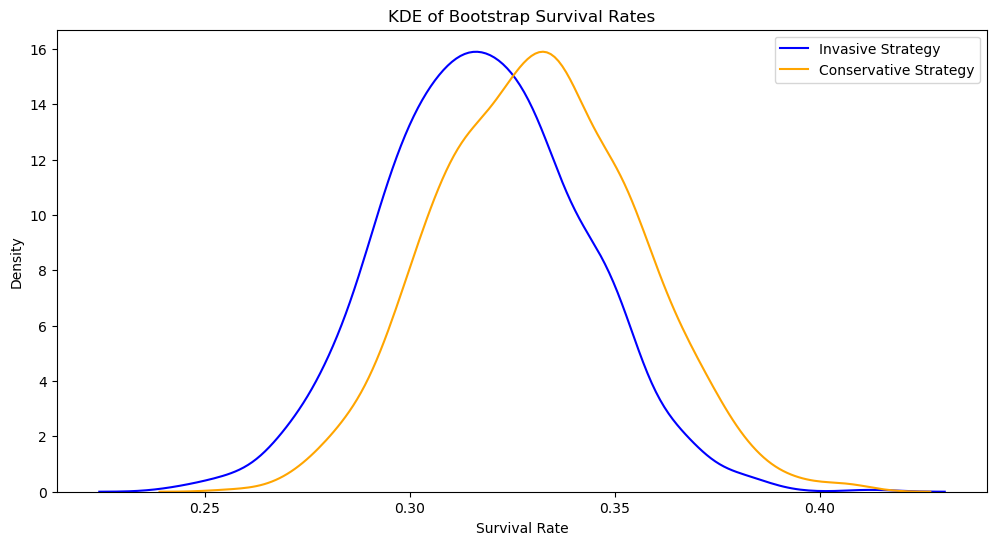

In [9]:
# Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data from the study
data = {
    'treatment': ['invasive'] * 388 + ['conservative'] * 389,
    'outcome': [1] * 123 + [0] * (388 - 123) + [1] * 129 + [0] * (389 - 129)
}

df = pd.DataFrame(data)

# Function to bootstrap survival rates
def bootstrap_survival_rate(data, n_bootstrap=1000):
    rates = []
    for _ in range(n_bootstrap):
        sample = data.sample(frac=1, replace=True)
        rate = sample['outcome'].mean()
        rates.append(rate)
    return np.array(rates)
# Bootstrap survival rates for both groups
invasive_rates = bootstrap_survival_rate(df[df['treatment'] == 'invasive'])
conservative_rates = bootstrap_survival_rate(df[df['treatment'] == 'conservative'])

# Plot KDEs
plt.figure(figsize=(12, 6))
sns.kdeplot(invasive_rates, label='Invasive Strategy', color='blue')
sns.kdeplot(conservative_rates, label='Conservative Strategy', color='orange')
plt.title('KDE of Bootstrap Survival Rates')
plt.xlabel('Survival Rate')
plt.ylabel('Density')
plt.legend()
plt.show()

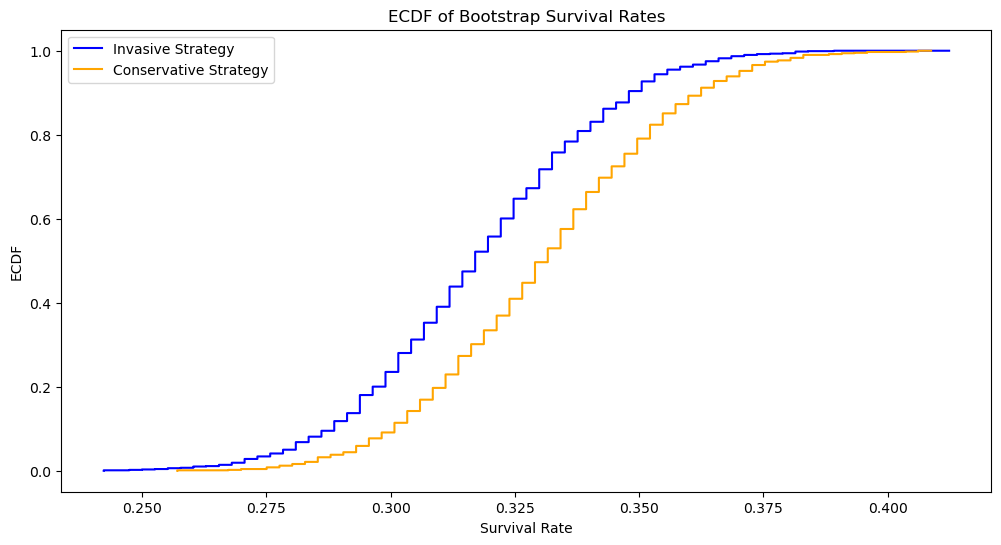

In [10]:
# ECDFs
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

# Plot ECDFs
plt.figure(figsize=(12, 6))
x_invasive, y_invasive = ecdf(invasive_rates)
x_conservative, y_conservative = ecdf(conservative_rates)
plt.step(x_invasive, y_invasive, label='Invasive Strategy', color='blue')
plt.step(x_conservative, y_conservative, label='Conservative Strategy', color='orange')
plt.title('ECDF of Bootstrap Survival Rates')
plt.xlabel('Survival Rate')
plt.ylabel('ECDF')
plt.legend()
plt.show()

When looking at the KDE and ECDF plots of the bootstrap survival rates for the invasive and conservative strategies, we can observe the following: The KDE plot shows the distribution of survival rates for both treatment strategies. The conservative strategy has a slightly higher peak, indicating a higher density of survival rates around the mean. However, the distributions overlap significantly, suggesting that there is considerable uncertainty in the survival rates for both strategies. The invasive strategy has a wider spread, indicating more variability in the survival rates.

#### Boostrap difference in Survival Rates

In [13]:
def diff_survival_rate(df_sample):
    surv_invasive = df_sample.loc[df_sample["treatment"]=="invasive", "outcome"].mean()
    surv_conservative = df_sample.loc[df_sample["treatment"]=="conservative", "outcome"].mean()
    return surv_invasive - surv_conservative

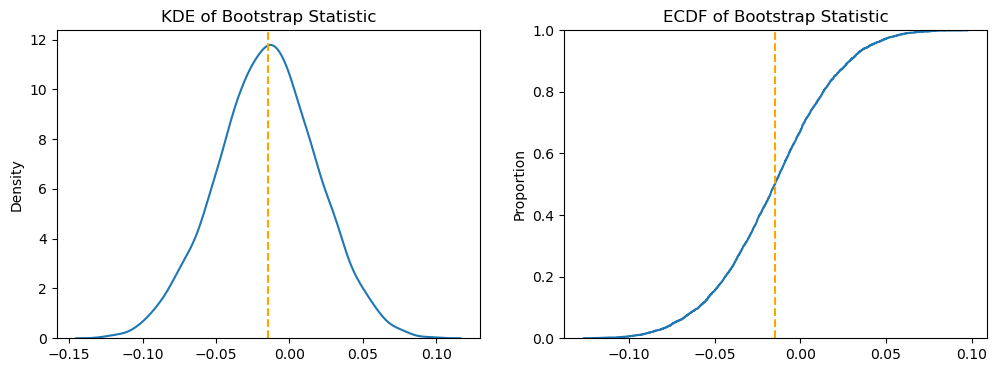

Variance of estimates is: 0.0011648453523097067


In [15]:
def simulate_df(df, fcn, S=1000, plot=True):
    estimates = []
    for s in range(S):
        # Bootstrap sample of rows:
        df_s = df.sample(frac=1.0, replace=True)
        # Compute statistic:
        stat_s = fcn(df_s)
        estimates.append(stat_s)
    estimates = np.array(estimates)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.kdeplot(estimates, ax = axes[0]).set(title='KDE of Bootstrap Statistic')
        axes[0].axvline(x=fcn(df), color='orange', linestyle='--')

        sns.ecdfplot(estimates, ax = axes[1]).set(title='ECDF of Bootstrap Statistic')
        axes[1].axvline(x=fcn(df), color='orange', linestyle='--')

        plt.show()
        print(f'Variance of estimates is: {np.var(estimates)}')

    return estimates

estimates = simulate_df(df, diff_survival_rate, S=5000)


### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

### Exercise 5
- Extend the `kde` class by adding a method to do bandwidth selection using a simple train-test split
- Extend the `kde` class by adding a method to do bandwidth seleciton by $k$-fold cross validation

### Exercise 6
In this exercise, you're going to do for LCLS what we just did for KDE: Pick the bandwidth 

Recall, the LCLS estimator is
$$
\hat{y}_{N,h}(z) = \dfrac{\frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left(\frac{z-x_i}{h}\right)}{\frac{1}{N} \sum_{i=1}^N \frac{1}{h}k\left(\frac{z-x_i}{h} \right)}.
$$
- Select two numeric variables from a data set. Split the data into training and test sets.
- Write a `predict(X_{train},Y_{train},X_{train})` function/method that takes a set of values $X_{test}$ and data $(X_{train},Y_{train})$, and computed predicted values $\hat{y}(X_{test})$ 
- Write a function/method that selects the bandwidth by **minimizing** the **mean squared error** of the squared differences between $\hat{y}(x_j)$ and $y_j$ on the test set:
$$
MSE(h) = \frac{1}{N_{test}} \sum_{j=1}^{N_{test}} (y_j - \hat{y}_{N_{train},h}(x_j))^2
$$
Be sure you understand what's happening here: The training data are used to make predictions for each test observation $x_j$, and then the prediction $\hat{y}(x_j)$ and true value $y_j$ are compared using squared difference